***Introduction***

***Problem Statement***

***Data Description***

***Exploratory Data Analysis***

In [2]:
pip install opendatasets --upgrade --quiet

In [3]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
import opendatasets as od
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

# DataPrep
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [5]:
download_url = 'https://www.kaggle.com/olistbr/brazilian-ecommerce/download'

od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poojashreens
Your Kaggle Key: ··········


100%|██████████| 42.6M/42.6M [00:00<00:00, 145MB/s]


In [7]:
data = pd.read_csv("/content/brazilian-ecommerce/olist_customers_dataset.csv")
geo_data = pd.read_csv("/content/brazilian-ecommerce/olist_geolocation_dataset.csv")
order_itemdata = pd.read_csv("/content/brazilian-ecommerce/olist_order_items_dataset.csv")
pay_data = pd.read_csv("/content/brazilian-ecommerce/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("/content/brazilian-ecommerce/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/brazilian-ecommerce/olist_orders_dataset.csv")
order_prddata = pd.read_csv("/content/brazilian-ecommerce/olist_products_dataset.csv")
order_selldata = pd.read_csv("/content/brazilian-ecommerce/olist_sellers_dataset.csv")
order_prd_catdata = pd.read_csv("/content/brazilian-ecommerce/product_category_name_translation.csv")

**Check number of columns and rows in all datasets**



In [10]:
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Blues_r')

,dataset,no_of_columns,columns_name,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095
8,category_translation,2,"product_category_name, product_category_name_english",71


**Observations:**

Dataset with maximum number of columns is products.

Dataset with maximum number of rows is geolocations.

**Checking dtypes**

In [12]:
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Blues_r')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
6,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0
8,category_translation,0,,2,"product_category_name, product_category_name_english",0


**Observations:**

products dataset has maximum number of numerical features(i.e dtype :'int16', 'int32', 'int64', 'float16', 'float32', 'float64').

Orders dataset has maximum number of features of object dtype.

We can also observe that all the timestamps are in object datatypes.So, we have to convert it into datetime type to do analysis on these features.

**Checking no of null values**

In [13]:
#code source-https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Blues_r')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,
8,category_translation,"product_category_name, product_category_name_english",2,0,0,


**Observations**

The maximum number of null-values are present in reviews dataset and the name of the columns with the null-values are review_comment_title and review_comment_message.

Products dataset contains least number of null- values but most of its columns has null-values.

**Eliminating review columns**

In [14]:
rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

**Merging all datasets**

In [15]:
df = pd.merge(orders,pay_data, on="order_id")
df = df.merge(data, on="customer_id")
df = df.merge(order_itemdata, on="order_id")
df = df.merge(order_prddata, on="product_id")
df = df.merge(order_prd_catdata, on="product_category_name")
df = df.merge(rev_new, on="order_id")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."


In [17]:
df.shape

(115609, 33)

Dataset has 115609 and 33 columns.

**Handling missing values**

In [18]:
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date      1195
order_delivered_customer_date     2400
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty       

**Observations**

Timestamps containg missing values are order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.

Null-values in order_approved_at can be replaced by order_purchase_timestamp and
null-values in order_delivered_customer_date can be replaced by order_estimated_delivery_date

we can drop the column order_delivered_carrier_date.

Product related details can be filled by taking median of those columns.

Review comments can be filled using "No review" string.

In [19]:
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

# null values in order_approved_at replaced by order_purchase_timestamp.
df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)

# null values in order_delivered_customer_date replaced by order_estimated_delivery_date.
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [21]:
# Handling missing product dimension values 
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [22]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('nao_reveja',inplace=True)

Percentage of null reviews : 57.697065107387836 %


In [24]:
df.shape

(115609, 32)

**Data Deduplication**

In [25]:
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
8,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,2,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
9,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,3,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
10,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,4,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja


In [26]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, keep='first', inplace=False)
df=df.reindex()
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3,nao_reveja
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21 00:00:00,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,1,"Inicialmente, na data da compra o produto era ..."


In [27]:
df.shape

(96516, 32)

**Data Analysis**

In [28]:
# all time stamps are in object dtype as observed above converting it into dataetime 
df[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date',]]=df[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

**Understaning review scores**

In [29]:
df.review_score.value_counts()

5    56185
4    18732
1    10598
3     7978
2     3023
Name: review_score, dtype: int64

**Method to group review scores from 1 - 5 to 0 or 1 (negative or positive)**

In [30]:
def group_review(x):
    if x < 3:
        return 0
    return 1
df['review_score']=df['review_score'].map(lambda cw : group_review(cw) ) 
    
# checking the review score now
df.review_score.value_counts()

1    82895
0    13621
Name: review_score, dtype: int64

Total Positive Reviews : 82895 , ( 85.8873140204733 %)
Total Negative Reviews : 13621 , ( 14.11268597952671 %)




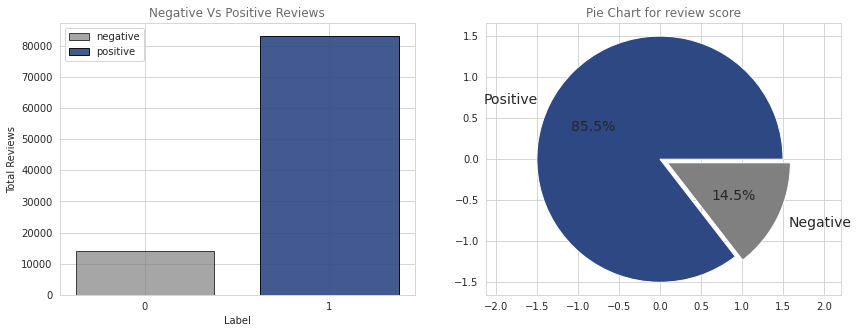

In [31]:
#counting the review score with 1 and 0
y_value_counts = df.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'grey', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = '#2e4884', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'#2e4884','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()

**Observations:**

Positive review comments are 85.88% where as negative review comments are 14.11%. With this we can infer that dataset is imbalanced.

**Correlation matrix**

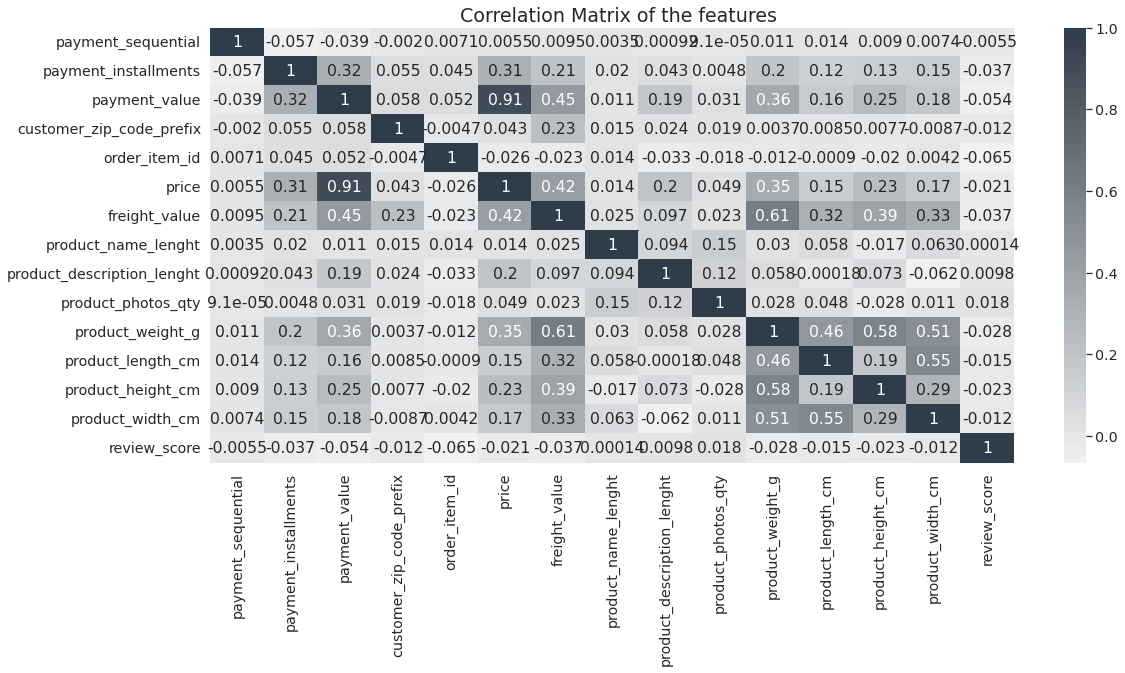

In [42]:
corr_matrix = df.corr()

plt.figure(figsize=(18,8))
sns.set(font_scale=1.3)
cmap = sns.light_palette("#2f3c49",as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap,annot=True)
plt.title("  Correlation Matrix of the features",fontsize=19)
plt.show()

**Observations**

There is a strong correlation between: 

1. payment_value and price

2. product_weight_g and freight_value also with product_width_cm

3. product_length_cm and product_width_cm

4. product_height_cm and product_weight_g

**Finding correlation values wrt features and review_score**

In [34]:
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.018062
product_description_lenght    0.009772
product_name_lenght           0.000142
payment_sequential           -0.005510
product_width_cm             -0.011653
customer_zip_code_prefix     -0.012370
product_length_cm            -0.015065
price                        -0.021429
product_height_cm            -0.023263
product_weight_g             -0.028432
freight_value                -0.036847
payment_installments         -0.037339
payment_value                -0.053558
order_item_id                -0.065218
Name: review_score, dtype: float64

**Payment type analysis**

In [35]:
df.groupby('payment_type').size()

payment_type
boleto         19203
credit_card    73251
debit_card      1484
voucher         2578
dtype: int64

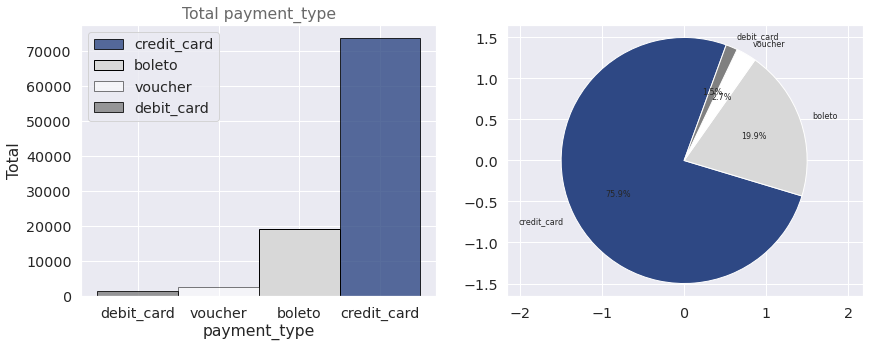

In [36]:
%matplotlib inline
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total')
plt.xlabel('payment_type')
plt.title('Total payment_type',color='dimgrey')
plt.xticks([10,10.25,10.50,10.75],['debit_card','voucher','boleto','credit_card'])
#creating bar plots
plt.bar(10.75,73816, color = '#2e4884', width = 0.25,alpha=0.8,label='credit_card',edgecolor='black')
plt.bar(10.50,19345, color = '#d8d8d8', width = 0.25,label='boleto',edgecolor='black')
plt.bar(10.25,2604, color = 'white', width = 0.25,alpha=0.5,label='voucher',edgecolor='black')
plt.bar(10,1490, color = 'grey', width = 0.25,alpha=0.8,label='debit_card',edgecolor='black')



plt.legend()

plt.subplot(1,2,2)
s= [ 73816,19345, 2604,1490]
new = ['credit_card','boleto','voucher','debit_card']

explode = (0, 0, 0,0)  
colours = {'credit_card': '#2e4884',
           'boleto': '#d8d8d8',
           'voucher': 'w',
           'debit_card': 'grey'}

color ={'#2e4884','grey','#d8d8d8','w'}



plt.pie(s, explode=explode, labels=new,colors=[colours[key] for key in new] , autopct='%1.1f%%',shadow=False, startangle=70,radius=1.5,frame=True,textprops={'fontsize': 8})
plt.axis('equal') 
plt.show()

In [37]:
temp = pd.DataFrame(df.groupby('payment_type')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

temp['total'] = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp['Avg']   = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])

#sorting dataframe
temp = temp.sort_values(by=['total'], ascending=True)

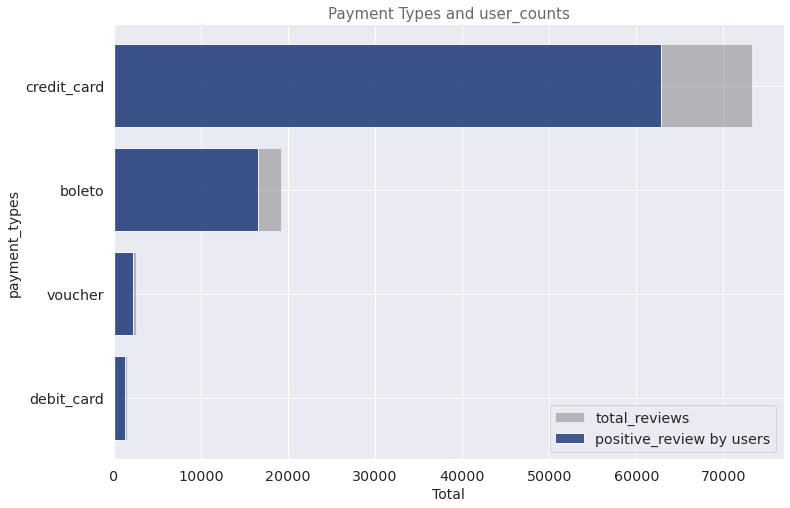

In [38]:
#Let us see how this categorical feature related with our target variable

plt.figure(figsize=(12,8))
p1=plt.barh(temp.payment_type,temp.total,color='grey',alpha=0.5)
p2=plt.barh(temp.payment_type,temp.review_score,color='#2e4884',alpha=0.9)
plt.title('Payment Types and user_counts',fontsize=15,color='dimgrey')
plt.ylabel('payment_types',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review by users'))

plt.show()

This can be one of the important categorical feature

**Univariant analysis of State**

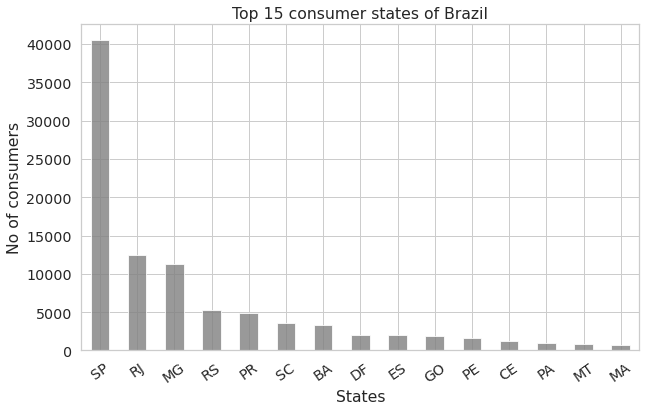

In [47]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.customer_state.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer states of Brazil")
ax.set_xlabel("States")
plt.xticks(rotation=35)
ax.set_ylabel("No of consumers")
plt.show()

**Observation(s):**

42% of total consumers are from the SP(São Paulo), 12.9 % are from RJ(Rio de Janeiro) and 11.7 % are from MG(Minas Gerais) which means most of consumers are from these states.

In [43]:
def stack_plot(data, xtick, col2, col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values,color = 'grey',alpha=0.5)
    p2 = plt.bar(ind, data[col2].values,color= '#2e4884',alpha=0.8)

    plt.ylabel('Reviews')
    plt.title('% of review_score  ')
    plt.xticks(ind-0.1, list(data[xtick].values), rotation=0)
    plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review'))
    plt.show()

**Types of reviews provided by cutomers of each state**

In [45]:
temp_1 = pd.DataFrame(df.groupby('customer_state')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

temp_1['total'] = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_1['Avg']   = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_1= temp_1.rename(columns={'review_score':'positive_review'})
temp_1= temp_1.sort_values(by=['total'], ascending=False)

In [48]:
temp_1

,customer_state,positive_review,total,Avg
25,SP,35697,40536,0.880625
18,RJ,9907,12410,0.798308
10,MG,9851,11297,0.872001
22,RS,4641,5331,0.870568
17,PR,4319,4902,0.881069
23,SC,3031,3526,0.859614
4,BA,2671,3277,0.815075
6,DF,1779,2084,0.853647
7,ES,1694,1981,0.855124
8,GO,1668,1946,0.857143


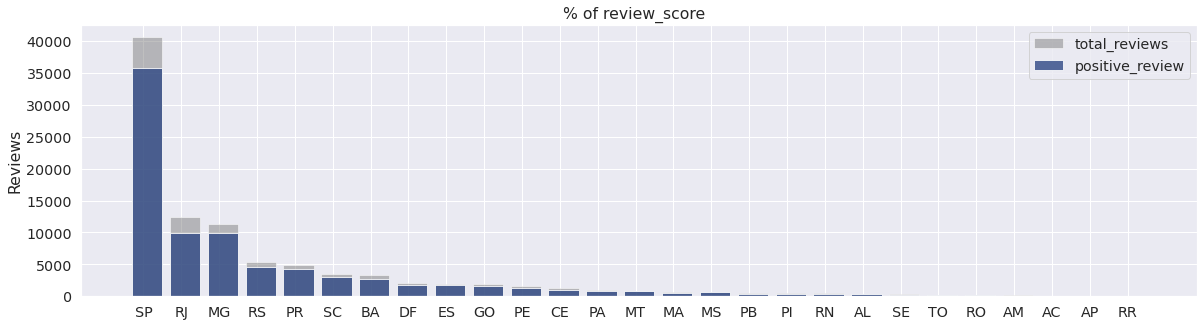

In [46]:
stack_plot(temp_1,'customer_state',col2='positive_review', col3='total')

From the avove stack plot of reviews per state we can conclude that most of consumers from each state has given positive reviews.In SP state from the total reviews of 40800 , 35791 reviews are positive reviews and for RJ state 9968 reviews are positive from the total reviews 12569.

**Univarient analysis of products**

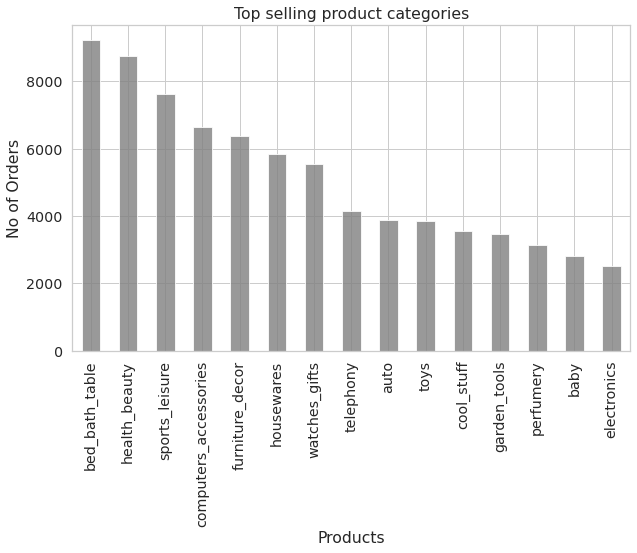

In [50]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.product_category_name_english.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("Products")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

**Analysis of frequency of orders vs customers**

Text(0.5, 1.0, 'Number of orders per customer')

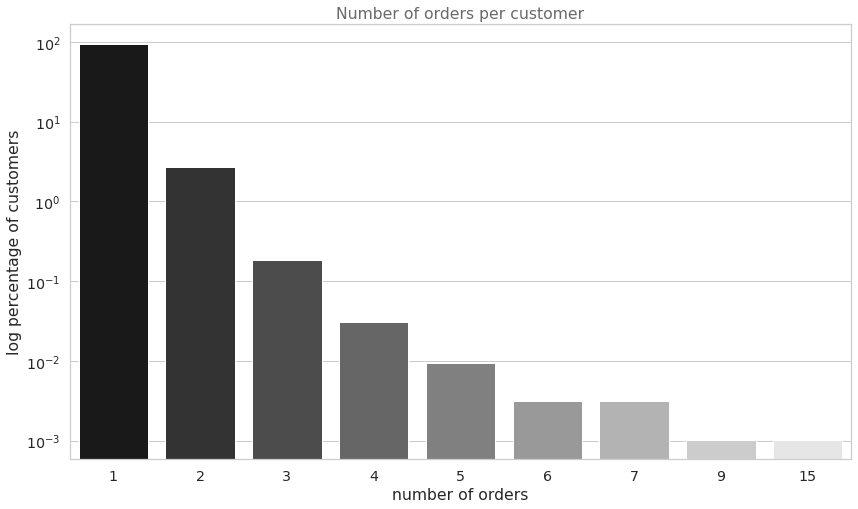

In [51]:
# plotting frequency orders vs  the number of consumers 
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
num_orders=df['customer_unique_id'].value_counts().value_counts()/df.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='gray')
plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

**Observations**

Most of the consumer given order of any products only for one times and few consumers are also present who oredred products more than 35 times. From this we can say order frequecy can be used as important feature for the problem.

**Performing operations on timestamps**

In [52]:
#calulating number of days for the data is taken
print(df.order_approved_at.max() - df.order_approved_at.min(), ' from ', 
      df.order_approved_at.min(), ' to ', df.order_approved_at.max())

699 days 07:56:34  from  2016-10-04 09:43:32  to  2018-09-03 17:40:06


In [53]:
#code source-https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

# Extracting attributes for purchase date - Year and Month
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year) #gives year Example :2016-10-04 09:43:32 ---->2016
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month) #gives month Example :2016-10-04 09:43:32 ---->10
df['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))#gives month in short form Example :2016-10-04 09:43:32 ---->10--> Oct
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))#gives month&year Example :2016-10-04 09:43:32 ---->201610
df['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))#gives month,yr and date  Example :2016-10-04 09:43:32 ---->20161004
df['order_purchase_month_yr'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime("%b-%y"))

# Extracting attributes for purchase date - Day and Day of Week
df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df['order_purchase_time_day'] = pd.cut(df['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_month_yr,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Não testei o produto ainda, mas ele veio corre...",2017,10,Oct,201710,20171002,Oct-17,2,0,Mon,10,Morning
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,Deveriam embalar melhor o produto. A caixa vei...,2017,8,Aug,201708,20170815,Aug-17,15,1,Tue,18,Afternoon
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,"Só achei ela pequena pra seis xícaras ,mais é ...",2017,8,Aug,201708,20170802,Aug-17,2,2,Wed,18,Afternoon
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,nao_reveja,2017,10,Oct,201710,20171023,Oct-17,23,0,Mon,23,Night
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,0,"Inicialmente, na data da compra o produto era ...",2017,11,Nov,201711,20171124,Nov-17,24,4,Fri,21,Night


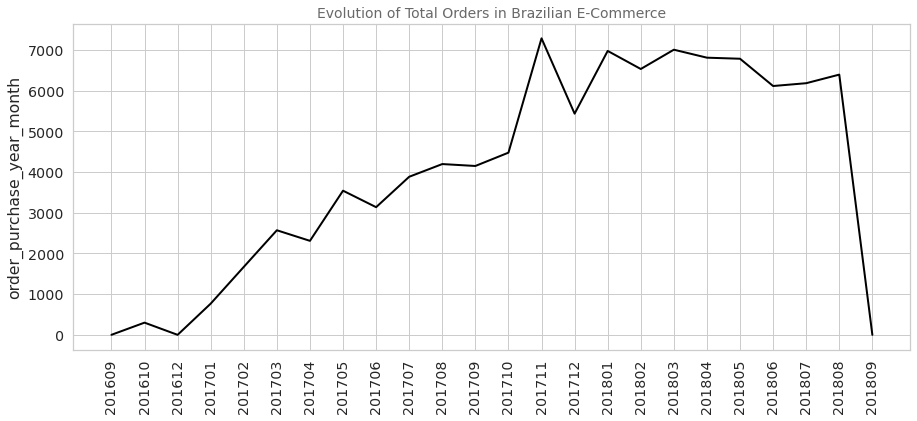

In [54]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df['order_purchase_year_month'].value_counts().sort_index(), 
             color='black', linewidth=2)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')
plt.xticks(rotation=90)
plt.show()

**Observations:**

There is a increase in purchase from 2016 to 2018. Highest sales was in 2017 November

**Corelating orders over year with review scores**

In [55]:
df_month = pd.DataFrame()
df_month['date'],df_month['review_score']= list(df.order_approved_at),list(df.review_score)
df_month=df_month.dropna()
df_month = df_month.sort_values(by=['date'])

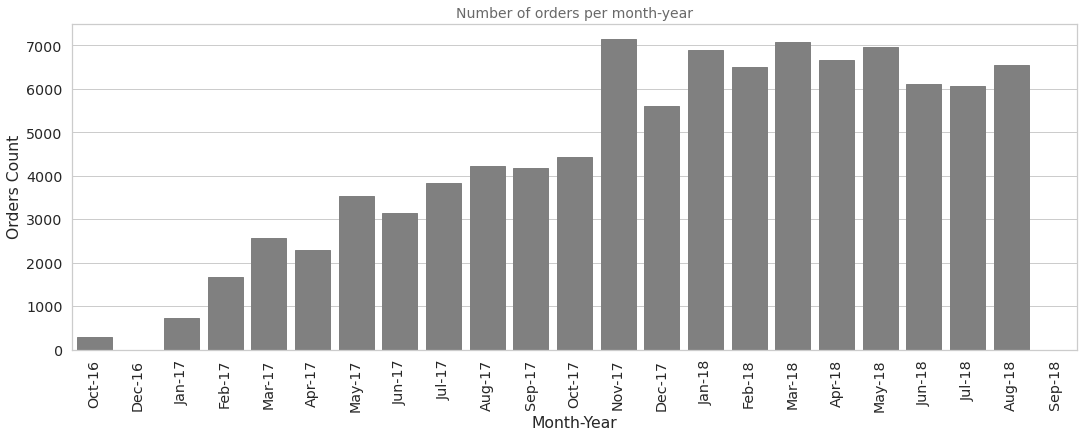

In [56]:
df_month['monthcount'] = list(df_month.date.apply(lambda x: x.strftime("%b-%y")))
#plotting number of orders per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,data=df_month,color='grey',edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of orders per month-year', size=14, color='dimgrey');

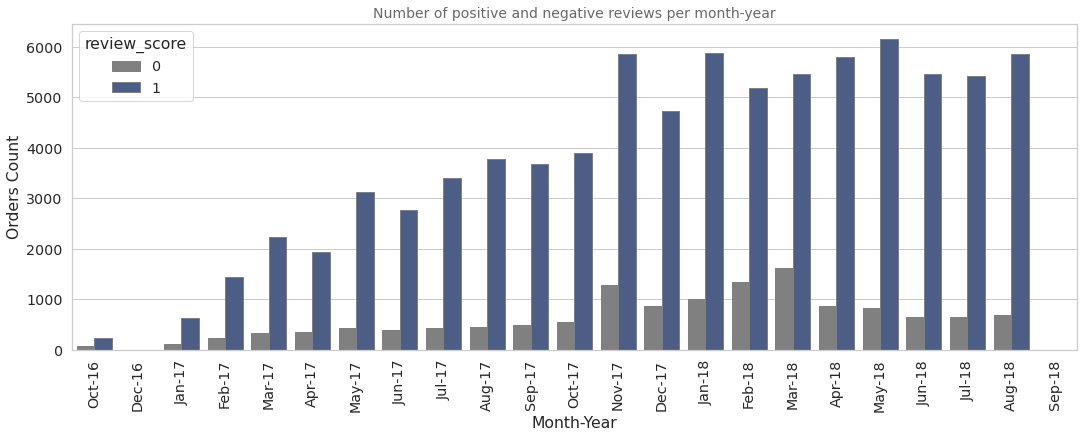

In [57]:
#plotting number of positive and negative reviews per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,hue='review_score',data=df_month,palette=['grey','#425a90'],edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of positive and negative reviews per month-year', size=14, color='dimgrey');

**Observation**

Highest positive reviews were in the month of May 2018

**Order Delivery date wrt review score**

In [59]:
df['day_to_delivery']=((df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days)

In [ ]:
df_dev = pd.DataFrame()
df_dev['day_to_delivery'],df_dev['review_score']= list(df.day_to_delivery),list(df.review_score)
df_dev=df_dev.dropna()

In [ ]:
plt.figure(figsize=(22,6))
plt.title('Order Counts Based on Total delivery Time(in Days)', color='dimgrey')
g = sns.countplot(x=df_dev.day_to_delivery,data=df_dev,color='gray')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Total Days')
g.set_ylabel('Orders Count');